# Simulating Quantum Errors

Author: Chengyi Tang

Date: April 28, 2024

Course: PHYS064 - Mathematical and Computational Methods for Physicists

In this project, I will introduce errors in quantum computing, build composite noise models, then apply noise models to quantum circuits to test their impact. For basics of quantum computing and quantum errors, please consult the writeup portion of this project.

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

## Constructing Quantum Errors

Some code in this section is taken from qiskit documentation at https://qiskit.github.io/qiskit-aer/tutorials/4_custom_gate_noise.html.

### Single Qubit Errors

The most basic types of errors in quantum computing are bit-flip and phase-flip errors. Given a quantum state $\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$, the bit-flip error changes the state to $\ket{\psi} = \beta \ket{0} + \alpha \ket{1}$ and the phase-flip error changes the state to $\ket{\psi} = \alpha \ket{0} - \beta \ket{1}$. In the following code, we assume a 5% error rate:

In [3]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


We can also construct composite errors:

In [4]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


The four types of errors above form a complete basis for all the single-qubit errors that could occur.

Another type of error that could occurs is a readout error, where the recorded classical value differes from the actual measured value:

In [5]:
readout_error = ReadoutError([[0.9, 0.1], [0.25, 0.75]])
print(readout_error)

ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.9 0.1]
 P(j|1) =  [0.25 0.75]


### Multiple Qubit Errors and Noise Models

The first way to construct multiple-qubit errors is by performing the tenwor product of two errors:

In [6]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


A more comprehensive way that combines composition and tensor products is a **noise model**, where we can specify the type of instruction it performs and which qubits it is applied to. We can perform errors on all qubits on specific qubits, which allows us to fine-tune our noise models.

We start with an all-qubit error with depolarizing errors. Depolarizing errors describes the decoherence of quantum information due to the interaction between a qubit and is environment.

In [7]:
# Create the Noise Model
noise_model_0 = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
d_error = depolarizing_error(0.05, 1)
noise_model_0.add_all_qubit_quantum_error(d_error, ['u1', 'u2', 'u3'], [0])

print(noise_model_0)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


We can specify which qubit we want to apply the error to by using the `add_quantum_error` function and specifying which qubits have errors associated with them:

In [8]:
noise_model_1 = NoiseModel()

noise_model_1.add_quantum_error(d_error, ['u1', 'u2', 'u3'], [0])

print(noise_model_1)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


Now we have specific qubit errors!

### Testing the Noise Models

Now we can test our noise models to see that they are actually outputting the errors we expect. To do this, we first construct a circuit with qiskit's `QuantumCircuit` class:

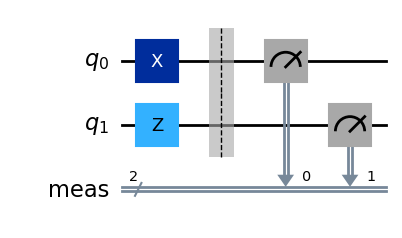

In [9]:
# create circuit object
qc_test = QuantumCircuit(2)

qc_test.x(0)
qc_test.z(1)
qc_test.measure_all()

# visualize the circuit
qc_test.draw('mpl')

For reference, we first run an ideal simulation of the circuit. Theoretically, the above circuit should output completely $\ket{01}$:

In [10]:
def get_multiple_counts(n_shots, qc, backend):
    '''
    run the circuit qc n_shots times on the backend and return the counts
    '''
    counts = {}
    for run in range(n_shots):
        result = backend.run(qc).result()
        result_counts = result.get_counts()
        for key in result_counts:
            if key in counts:
                counts[key] += result_counts[key]
            else:
                counts[key] = result_counts[key]
    return counts

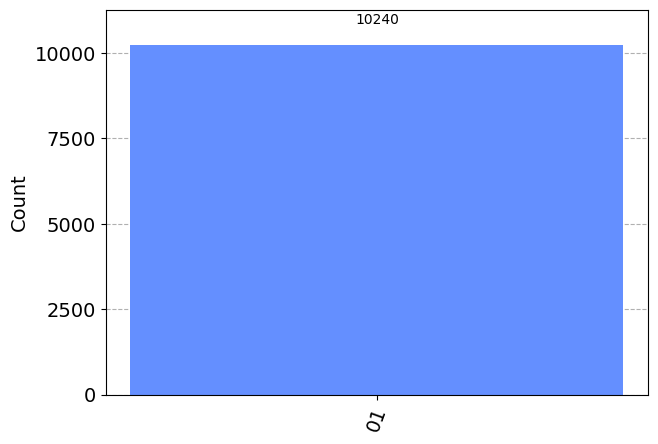

In [11]:
# create a backend
sim_ideal = AerSimulator()

# run the simulation 10 times since Aer only returns 1024 shots
counts_ideal = get_multiple_counts(10, qc_test, sim_ideal)
plot_histogram(counts_ideal)


They are all $\ket{01}$, as expected. Now we execute a noisy simulatioin with `noise_model_0`, which is the decoherence noise model we constructed above:

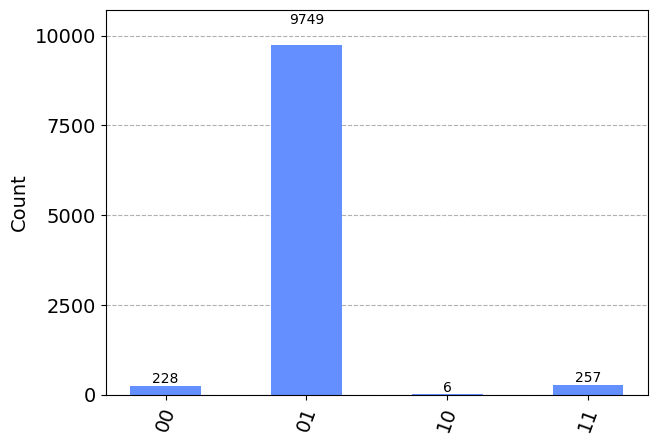

In [13]:
sim_noise = AerSimulator(noise_model=noise_model_0)
qc_test_tnoise = transpile(qc_test, sim_noise)

counts_noise = get_multiple_counts(10, qc_test_tnoise, sim_noise)
plot_histogram(counts_noise)

Now there is not only $\ket{01}$ present! We have single and double bit-flip errors (phase flip errors won't show up while measuring).

We can calculate the total variation distance (TVD) of this run, which calculates how much the noisy result matches the ideal result. The TVD ranges form 0 to 1. TVD values closer to 1 indicate greater deviation from the ideal run.

In [25]:
def get_tvd(ideal_counts, noisy_counts):
    # Get the union of keys from both distributions
    all_keys = set(ideal_counts.keys()) | set(noisy_counts.keys())

    # Calculate the total variation distance
    total_shots = sum(ideal_counts.values()) + sum(noisy_counts.values())
    tvd = 0.5 * sum(abs(ideal_counts.get(key, 0) - noisy_counts.get(key, 0)) for key in all_keys) / total_shots
    print(f'Total Variation Distance: {tvd:.5f}')
    return tvd

In [15]:
# Calculate the total variation distance
tvd = get_tvd(counts_ideal, counts_noise)

Total Variation Distance: 0.02397


Now, the noise clearly affects our result, but the TVD is still arbitrarily small. Decoherence has caused accidental X, Z, and XZ errors on our whole circuit. If we apply the noise model only on the first qubit, we would get instead:

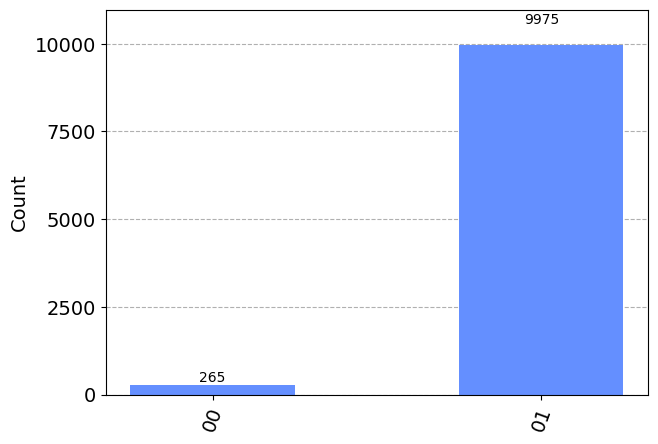

In [16]:
sim_noise = AerSimulator(noise_model=noise_model_1)
qc_test_tnoise = transpile(qc_test, sim_noise) # transpile the circuit into gates in sim_noise; we can do this from universal gate decomposition

counts_noise = get_multiple_counts(10, qc_test_tnoise, sim_noise)
plot_histogram(counts_noise)

Now, there are only errors on the first qubit. We calculate a TVD again:

In [17]:
tvd = get_tvd(counts_ideal, counts_noise)

Total Variation Distance: 0.01294


We see that the TVD while there is only error on the first qubit is only half of the TVD while there is error on both qubits.

## Applying Quantum Errors

### Shor's Algorithm Implementation

In this part, we want to construct one of the most iconoic quantum algorithms - Shor's algorithm for factoring - but with noise. The QFT part of my code is taken from an official qiskit tutorial: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb. The I modified the code to allow for simulation with errors.

The details of Shor's algorithm belongs to a separate project, so I will not explain here. Simply speaking, Shor's algorithm factors integers exponentially faster then classical algorithms, making it one of the most powerful quantum algorithms ever invented.

In [12]:
import matplotlib.pyplot as plt
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [13]:
# create modular exponential gates
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [14]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [15]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

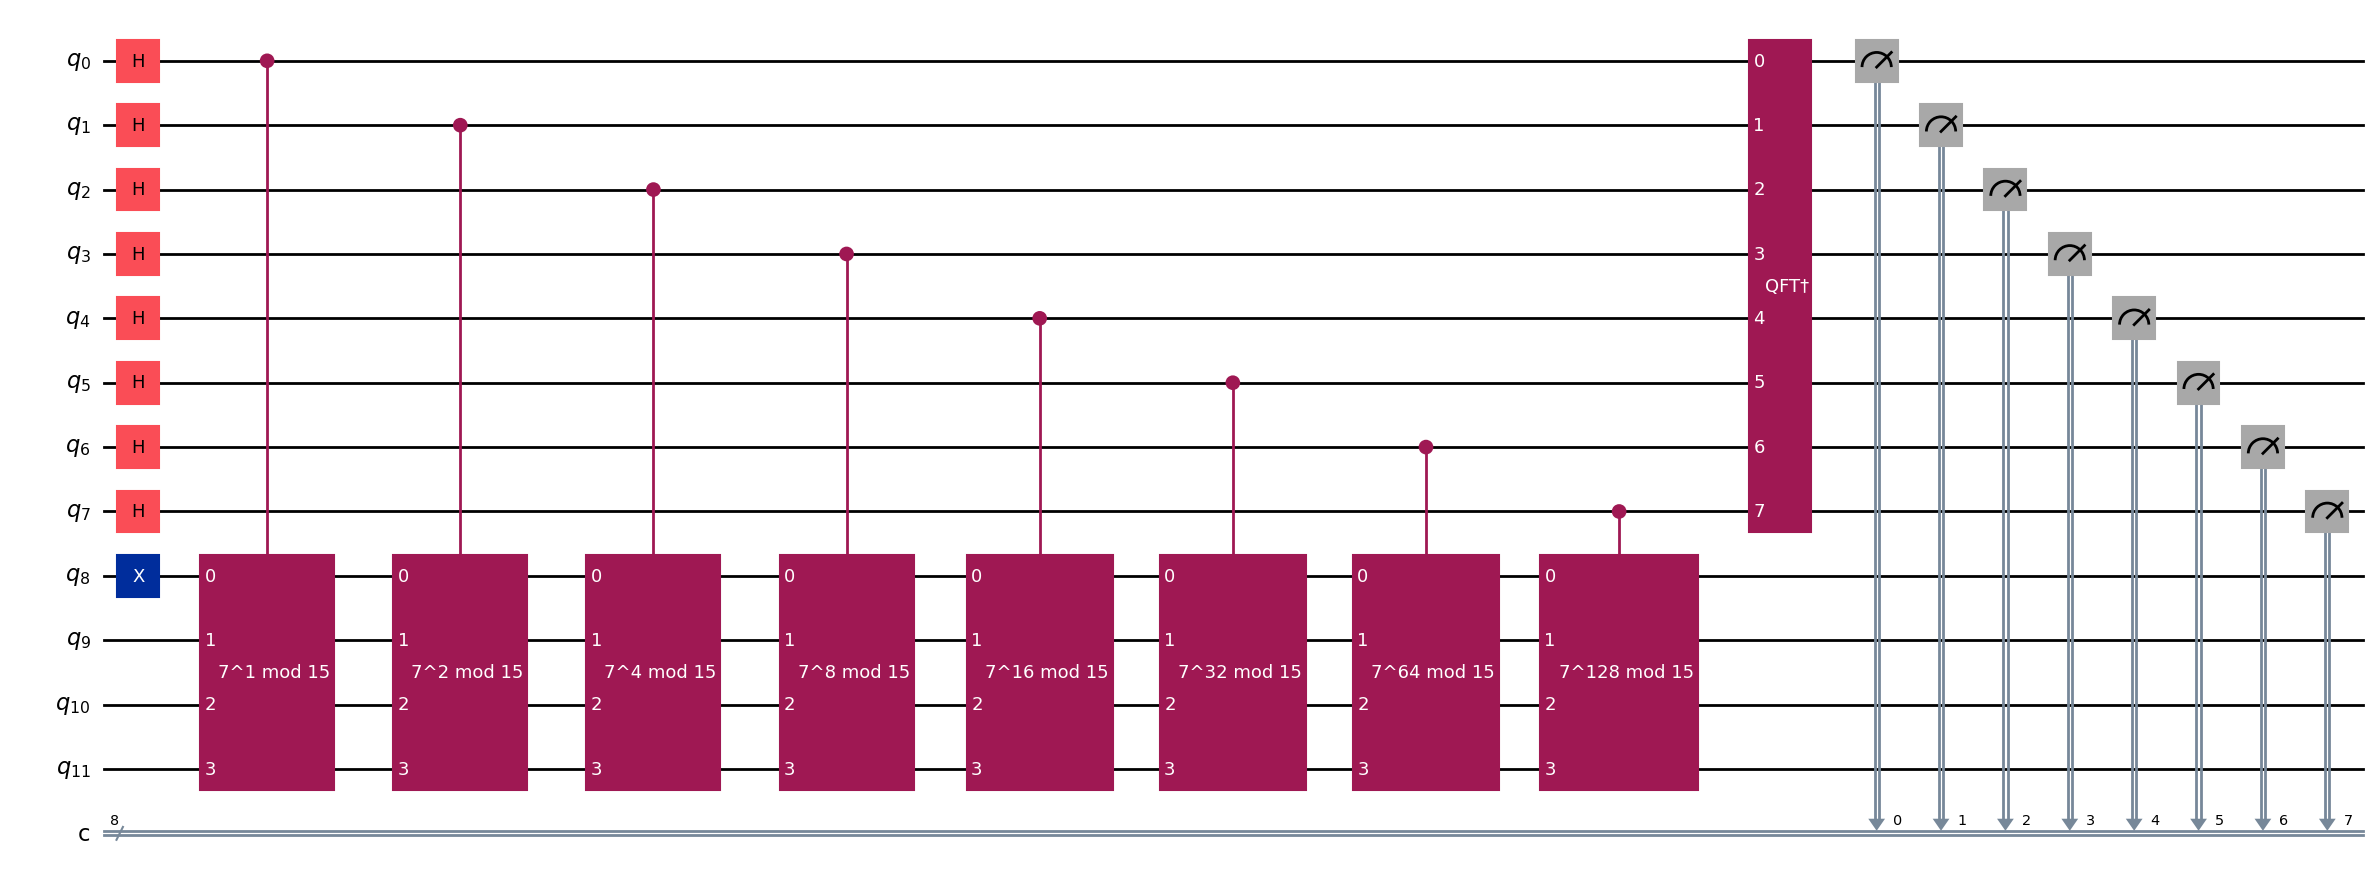

In [22]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl', fold=-1)  # -1 means 'do not fold'

The above circuit is the complete circuit for Shor's algorithm, involving controleld modular exponentiation and inverse quantum fourier transforms.

### Running Shor's Algorithm

Now we run Shor's algorithm with an ideal backend:

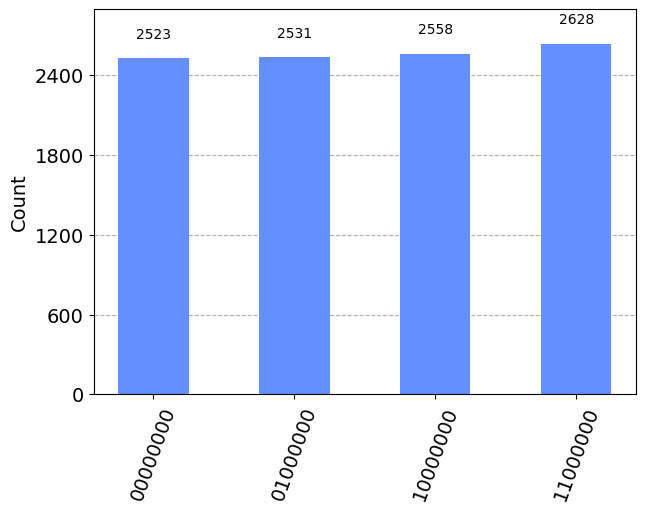

In [23]:
sim_ideal = AerSimulator()
t_qc = transpile(qc, sim_ideal)

# run the simulation 10 times since Aer only returns 1024 shots
counts_ideal = get_multiple_counts(10, t_qc, sim_ideal)
plot_histogram(counts_ideal)

The simulation returns an (approximately) equal number of $\ket{00000000}, \ket{01000000}, \ket{10000000}$, and $\ket{11000000}$. Each of the results represent a possible period in the inverse quantum Fourier transform. Here, there are a maximum of 4 possible periods. Now we proceed with the algorithm to find the associated phases and eventually factors from Shor's algorithm:

In [16]:
def get_phases(counts, N_COUNT):
    rows, measured_phases = [], []
    for output in counts:
        decimal = int(output, 2)  # Convert (base 2) string to decimal
        phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
        measured_phases.append(phase)
        frac = Fraction(phase).limit_denominator(15)
        rows.append([phase,
                    f"{frac.numerator}/{frac.denominator}",
                    frac.denominator])
    # Print as a table
    headers=["Phase", "Fraction", "Guess for r"]
    df = pd.DataFrame(rows, columns=headers)
    return df

In [25]:
get_phases(counts_ideal, N_COUNT)

,Phase,Fraction,Guess for r
0,0.00,0/1,1
1,0.50,1/2,2
2,0.75,3/4,4
3,0.25,1/4,4


In [17]:
def qpe_amod15(a, N_COUNT, noise_model = None):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = AerSimulator(noise_model=noise_model)
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [18]:
def Shor(a, N, noise_model=None):
    '''
    Shor's Algorithm for factoring
    Args:
        a (int): The base of the exponentiation
        N (int): The number to factor
        noise_model (NoiseModel): The noise model to apply to the simulation
    Returns:
        factors (list): The non-trivial factors of N
    '''
    phase = qpe_amod15(a, 8, noise_model)
    FACTOR_FOUND = False
    ATTEMPT = 0
    factors = []
    while not FACTOR_FOUND:
        ATTEMPT += 1
        print(f"\nATTEMPT {ATTEMPT}:")
        phase = qpe_amod15(a, 8, noise_model) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        print(f"Result: r = {r}")
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0:
                    # Guess is a factor!
                    factors.append(guess)
                    print(f"*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True
    return factors

In [28]:
Shor(8, 15)

Register Reading: 01000000
Corresponding Phase: 0.25

ATTEMPT 1:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


[3, 5]

Shor's algorithm works, as expected. We are able to factor 15 at first attempt with a relatively short run time (1.1s). Note that since we used 11 qubits, we are operating on $\mathcal{O}(2^{11})$ space and time!

### Construct General Noise Model

Now that we show that Shor's algorithm works, we will apply a noise model to the algorithm and compare the results with the ideal case. The noise model we will use is the thermal relaxation model. There are two types of relaxation: (1) T1 relaxation (energy relaxation), in which the excited state decays towards the ground state $\ket{1}$ goes to $\ket{0}$; (2) T2 relaxation (dephasing), in which the phase difference between $\ket{0}$ and $\ket{1}$ decays over time.

In [19]:
# Create the noise model
noise_model = NoiseModel()

Now we add the thermal relaxation errors:

In [20]:
def create_thermal_model(noise_model, n):
    # T1 and T2 values for qubits 0-(n-1)
    T1s = np.random.normal(50e3, 10e3, n) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, n)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                    for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, time_cx))
                for t1a, t2a in zip(T1s, T2s)]
                for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    for j in range(n):
        noise_model.add_quantum_error(errors_reset[j], "reset", [j])
        noise_model.add_quantum_error(errors_measure[j], "measure", [j])
        noise_model.add_quantum_error(errors_u1[j], "u1", [j])
        noise_model.add_quantum_error(errors_u2[j], "u2", [j])
        noise_model.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(n):
            noise_model.add_quantum_error(errors_cx[j][k], "cx", [j, k])

create_thermal_model(noise_model, 8)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'cx', 'measure', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,)), ('measure', (7,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u2', (7,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('u3', (7,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (0, 5)), ('cx', (0, 6)), ('cx', (0, 7)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (1, 5)), ('cx', (1, 6)), ('cx', (1, 7)), ('cx', (2, 0)), ('cx', (2, 1))

In [31]:
sim_noise = AerSimulator(noise_model=noise_model)
t_qc_noise = transpile(qc, sim_noise)

# run the simulation
counts_noise = get_multiple_counts(1, t_qc_noise, sim_noise)

In [32]:
len(counts_noise)

190

Since we measured 8 qubits, we see that out of the $2^8 = 256$ possible results, we obtained 190 - which suggests a really high error rate. Indeed, when we calculate the total variation distance for this simulation, we get 0.48, which suggests an extremely high error.

In [33]:
get_tvd(counts_ideal, counts_noise)

Total Variation Distance: 0.47550


0.4754971590909091

If we do attempt to use this result to find possible periods, we get all possible values for the period from 1 to 15. The run with error has told us nothing at all about the factors of 15.

In [34]:
result = get_phases(counts_noise, N_COUNT)
print(result)
print(len(result['Guess for r'].unique()))

        Phase Fraction  Guess for r
0    0.941406    14/15           15
1    0.617188     8/13           13
2    0.976562      1/1            1
3    0.367188     4/11           11
4    0.429688      3/7            7
..        ...      ...          ...
185  0.808594      4/5            5
186  0.757812      3/4            4
187  0.445312      4/9            9
188  0.562500      5/9            9
189  0.750000      3/4            4

[190 rows x 3 columns]
15


This speaks to how quantum errors are significantly limiting the power of quantum computing. With a circuit for a task as simple as factoring 15, a quantum computer with error can completely fail the task. We will need efficient methods for quantum error correction to fully exploit the power of quantum computing.

However, error correction codes are basically impossible to run on normal computers. In quantum computing, error correction codes often involve constructing logical qubits constiting of multiple qubits. One of the most powerful error-correcting codes is the Steane code, which requires 7 total qubits for the logical qubit, as well as 6 ancilla qubits for measuring parities. Running an algorithm on the order of $2^{13}$ with circuit depths of more than 1000 gates takes a very long time on normal computers. This scales exponentially with the number of qubits in the circuit. The Shor circuit we have above has 8 measured qubits, which means we would need space/time on the order of $2^{13\cdot 8} \approx 10^{31}$. This is impossible to run on almost any classical computer.

In [35]:
# check depth of transpiled Shor circuits
t_qc.depth(), t_qc_noise.depth()

(3298, 24035)

The error correction part of this project is in the `Tests.ipynb` file, contained in the same folder. There, I lay out the noise-compatible Steane code. Take a look if it is of interest!

# Conclusion

In this project, I started from the basics of quantum error, constructed composite noise models from baisc quantum errors, then applied the thermal relaxation model on the famonus Shor algorithm to show that basic quantum errors can render powerful quantum algorithms useless. This simulation indicates the importance of error correction in building truly powerful quantum computers.